In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import os
import numpy as np
import math
import matplotlib
import CreateHD5F as chdf5
import ImageViewer as iv
import SimpleITK as sitk
from matplotlib.lines import Line2D
import statsmodels.api as sm


#%matplotlib notebook

test
-- 256
---- input (24, 256, 256, 1)
---- patient_ids (24,)
----> Patient ids: [15.]
----> Patient ids: 1
---- target_an (24, 256, 256, 1)
-- 352
---- input (424, 352, 352, 1)
---- patient_ids (424,)
----> Patient ids: [ 3.  5.  9. 23. 24. 29. 38. 52. 79. 81. 83. 99.]
----> Patient ids: 12
---- target_an (424, 352, 352, 1)
train
-- 256
---- input (40, 256, 256, 1)
---- patient_ids (40,)
----> Patient ids: [16. 19.]
----> Patient ids: 2
---- target_an (40, 256, 256, 1)
-- 352
---- input (2222, 352, 352, 1)
---- patient_ids (2222,)
----> Patient ids: [ 1.  4.  6.  7. 17. 18. 20. 21. 22. 26. 27. 28. 30. 31. 32. 34. 35. 36.
 37. 39. 40. 41. 42. 43. 44. 45. 47. 49. 50. 51. 53. 55. 57. 58. 59. 60.
 62. 65. 66. 67. 68. 69. 70. 71. 72. 74. 75. 76. 77. 78. 84. 85. 86. 87.
 88. 89. 92. 93. 94. 95. 96.]
----> Patient ids: 61
---- target_an (2222, 352, 352, 1)
val
-- 256
---- input (65, 256, 256, 1)
---- patient_ids (65,)
----> Patient ids: [11. 13. 14.]
----> Patient ids: 3
---- target_an (65

In [2]:
def dataframe_of_f1scores(excel_path:str, sheet_name:str, filetype:list, range_ids, patient_ids=False):
    """
    The function takes in an excel file and creates a list of paths to the wanted file(s) (filetype).
    The wanted files are then converted to dataframes, and a singel dataframe containing all the
    'f1_scores' in the wanted files is returned.
    
    
    excel_path: path to excel file containing the paths to folders with experiment results
    sheet_name: name of the excel sheet you want to create a dataframe of
    filetype: filename of the file you want to collect from the result folder
    
    Returns a dataframe with all of f1_scores for the filetype for a given dataset.
    """
    dataframe = pd.read_excel(excel_path, sheet_name=sheet_name) #Create dataframe of excel sheet
    paths = list(dataframe['Result path']) #Get a list of folderpaths were the results are saved
    learning_rates = list(dataframe['Learning rate'])
    loss_functions = list(dataframe['Loss function'])
    IDs = list(dataframe['Experiment ID'])
    file_paths_352 = [] #List of paths for images with dimension 352x352
    file_paths_256 = [] #List of paths for images with dimension 256x256
    df = pd.DataFrame()

    for file in filetype:
        
        for i in range_ids:
            
            if (dataframe['Dataset'][0] == 'Oxytarget'): #If the dataset is Oxytarget then all the images have the same dimensions.
                paths[i] = paths[i] + '/' + file #List of paths for the patient.csv files
                if os.path.isfile(paths[i]): #Check if the file path exists
                    if df.empty: #Check if the dataframe is empty
                        df = pd.read_csv(paths[i]) #Add result to dataframe
                        df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[i])+ '+' +loss_functions[i]}, inplace=True) #Rename column
                        #df = df.rename(columns={'f1_score': IDs[i]})
                    else:
                        #If the dataframe is not empty, add columns with the score from the other results
                        df_temp = pd.read_csv(paths[i])
                        df = df.join(df_temp.set_index('patient_ids'), on='patient_ids')
                        df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[i])+ '+' +loss_functions[i]}, inplace=True)
                        #df = df.rename(columns={'f1_score': IDs[i]})
                
                    
            
            else: #For other datasets the images are of two different dimensions
                if file.endswith('352.csv'):
                    file_paths_352.append(str(paths[i]) + '/' + file)
                else:
                    file_paths_256.append(str(paths[i]) + '/' + file)
                
    if not dataframe['Dataset'][0] == 'Oxytarget':
        for i in range(len(file_paths_352)):
            if os.path.isfile(file_paths_352[i]) and os.path.isfile(file_paths_256[i]):

                if df.empty: #Check if the dataframe is empty
                    df_352 = pd.read_csv(file_paths_352[i])
                    df_256 = pd.read_csv(file_paths_256[i])
                    df = df_352.append(df_256, ignore_index=True)
                    df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[range_ids[i]])+ '+' +loss_functions[range_ids[i]]}, inplace=True) #Rename column
                    #df = df.rename(columns={'f1_score': IDs[i]})
                
                else:
                    #If the dataframe is not empty, add columns with the score from the other results
                    df_352 = pd.read_csv(file_paths_352[i])
                    df_256 = pd.read_csv(file_paths_256[i])
                    df_temp = df_352.append(df_256, ignore_index=True)
                    df = df.join(df_temp.set_index('patient_ids'), on='patient_ids')
                    df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[range_ids[i]])+ '+' +loss_functions[range_ids[i]]}, inplace=True) #Rename column
                    #df = df.rename(columns={'f1_score': IDs[i]})
                    
    if not patient_ids:
        df = df.drop(['patient_ids'], axis=1)
    
    return df

In [3]:
def swap_columns(df, c1, c2):
    """
    The function swaps the position of two columns (c1 and c2) in a dataframe (df).
    Returns new dataframe with swapped columns.
    """
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df = df.rename(columns={c1:c2, c2:c1})
    return df

In [4]:
def boxplot(dataframe, order, fontsize, labelsize, save=False):
    """
    The function creates boxplots based on learning rates and loss functions
    """
    fig = plt.figure()
    g = sns.FacetGrid(dataframe, col='Learning rate', row='Loss function', margin_titles=True)
    #g.map(sns.violinplot,'Data', 'value', order=order, scale='width', inner='box', cut=0, palette=['#9ecae1','#fdae6b','#a1d99b']) #['#3182bd','#e6550d','#31a354']) ['skyblue','orange','mediumseagreen'])
    g.map(sm.graphics.violinplot('Data', 'value', plot_opts={'cutoff_val':5}))
    #sns.set_style("whitegrid")
    #sns.reset_orig()
    g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    
    #ylabels = ['DSC', 'Modified DSC']
    row = 0
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large') 


        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='x-large')
        
        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    #'',
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
        row += 1
    g.set_xticklabels(rotation=30)
    g.set_axis_labels('', r'DSC$_{\mathrm{P}}$')
    #g.axes.flat[3].set_ylabel('Modified DSC', fontsize='x-large')
    #g.axes.flat[3].set_text('', fontsize='x-large')
    #g.set(ylim=(-0.35,1.1))
    g.set(ylim=(-0.05,1.05))
    plt.show()
    
    if save:
        g.savefig('hyperparameters_violinplot_cut0.pdf')
    
    

## Boxplots tuning hyperparameters (learning rate and loss function)

In [545]:
def main():
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    ids_Oxy = [5,6,7,8,9,10]
    ids_LARC = [5,6,7,8,9,10]
    ids_Comb = [0,1,2,3,4,5]
    #Creating dataframes of det f1 scores of the validation patients
    Oxy = dataframe_of_f1scores(excel_path, 'Oxy_new', ['patient.csv'], ids_Oxy)
    LARC = dataframe_of_f1scores(excel_path, 'LARC',['patient_352.csv','patient_256.csv'], ids_LARC)
    Combined = dataframe_of_f1scores(excel_path, 'Combined_new',['patient_352.csv','patient_256.csv'], ids_Comb) 
    
    
    #Creating dictionary of dataframes
    dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}
    
    #Column-names to be swapped
    col_names = list(Oxy.columns)
    
    for key in dictionary:               
        #Swapping order of columns
        dictionary[key] = swap_columns(dictionary[key], col_names[1], col_names[0])
        dictionary[key] = swap_columns(dictionary[key], col_names[4], col_names[3])
        
        #Re-organize the dataframe
        dictionary[key]['Data'] = key
    
    #Create one dataframe with all the datasets
    df = pd.concat([dictionary['OxyTarget'], dictionary['LARC-RRP'], dictionary['Combined']])
    df = pd.melt(df, id_vars=['Data'], var_name=['Parameters'])
    df[['Learning rate','Loss function']] = df.Parameters.apply(lambda x: pd.Series(str(x).split("+")))
    print(df)
    
    #Plot as boxplots
    order = ['OxyTarget','LARC-RRP','Combined']
    #boxplot(df, order, 12, 12, save=True)
    

In [546]:
main()

          Data           Parameters         value Learning rate  Loss function
0    OxyTarget           1e-03+Dice  7.392506e-01         1e-03           Dice
1    OxyTarget           1e-03+Dice  7.190135e-01         1e-03           Dice
2    OxyTarget           1e-03+Dice  5.561378e-01         1e-03           Dice
3    OxyTarget           1e-03+Dice  4.344768e-01         1e-03           Dice
4    OxyTarget           1e-03+Dice  7.340741e-01         1e-03           Dice
..         ...                  ...           ...           ...            ...
343   Combined  1e-05+Modified Dice  7.553955e-01         1e-05  Modified Dice
344   Combined  1e-05+Modified Dice  5.715861e-01         1e-05  Modified Dice
345   Combined  1e-05+Modified Dice  2.247023e-01         1e-05  Modified Dice
346   Combined  1e-05+Modified Dice  5.266761e-13         1e-05  Modified Dice
347   Combined  1e-05+Modified Dice  1.485222e-12         1e-05  Modified Dice

[348 rows x 5 columns]


In [972]:
def boxplot_2(dfs, order, fontsize, labelsize, colors, save=False):
    """
    The function creates boxplots based on learning rates and loss functions
    """
    fig, axes = plt.subplots(figsize=(11,8), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    matplotlib.rcParams.update({'axes.titlesize':fontsize})
    
    colnames = list(dfs[order[0]].columns)
    print(colnames)
    counter = 0
    
    for row in range(2):
        for column in range(3):
            for i in range(3):
                parts = axes[row,column].violinplot(dfs[order[i]][colnames[counter]],
                                        positions=[i], showmeans=False, showmedians=False, showextrema=False)
                
                for pc in parts['bodies']:
                    pc.set_facecolor('#808080')
                    #pc.set_facecolor(colors[i])
                    #pc.set_edgecolor('#4a6591')
                    #pc.set_alpha(0.4)
                    pc.set_alpha(0.2)
            
                axes[row,column].boxplot(dfs[order[i]][colnames[counter]],
                                         positions=[i], showmeans=False, meanline=False, 
                    patch_artist=True, boxprops=dict(facecolor=colors[i], color='k'), 
                    medianprops=dict(color='k'),meanprops=dict(color='k'))
        
            counter += 1
            
            axes[row,column].set(ylim=(-0.0,1.0))
            axes[row,column].grid(color='k', alpha=0.2, axis='y', linestyle='solid')
            axes[row,column].spines['right'].set_visible(False)
            axes[row,column].spines['top'].set_visible(False)
            
            for tick in axes[row,column].get_xticklabels():
                tick.set_rotation(15)
             
    axes[0,0].set(xlabel=' ', ylabel=r'DSC$_{\mathrm{P}}$')
    axes[1,0].set(xlabel=' ', ylabel=r'DSC$_{\mathrm{P}}$')
    
    axes[0,2].yaxis.set_label_position("right")
    axes[0,2].set_ylabel("Dice", rotation=0, labelpad=28)
    
    axes[1,2].yaxis.set_label_position("right")
    axes[1,2].set_ylabel("Modified Dice", rotation=0, labelpad=73)
    
    axes[0,0].set_title('1e-03')
    axes[0,1].set_title('1e-04')
    axes[0,2].set_title('1e-05')
    
    plt.xticks([0, 1, 2], [dfs['OxyTarget']['Data'][0], dfs['LARC-RRP']['Data'][0], dfs['Combined']['Data'][0]])
    plt.show()
    
    if save:
        fig.savefig('hyperparameters_violinplot_v2.pdf')
    

In [973]:
def main_2():
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    ids_Oxy = [5,6,7,8,9,10]
    ids_LARC = [5,6,7,8,9,10]
    ids_Comb = [0,1,2,3,4,5]
    
    #Creating dataframes of det f1 scores of the validation patients
    Oxy = dataframe_of_f1scores(excel_path, 'Oxy_new', ['patient.csv'], ids_Oxy)
    LARC = dataframe_of_f1scores(excel_path, 'LARC',['patient_352.csv','patient_256.csv'], ids_LARC)
    Combined = dataframe_of_f1scores(excel_path, 'Combined_new',['patient_352.csv','patient_256.csv'], ids_Comb) 
    
    #Creating dictionary of dataframes
    dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}
    
    #Column-names to be swapped
    col_names = list(Oxy.columns)
    
    for key in dictionary:               
        #Swapping order of columns
        dictionary[key] = swap_columns(dictionary[key], col_names[1], col_names[0])
        dictionary[key] = swap_columns(dictionary[key], col_names[4], col_names[3])
        
        #Re-organize the dataframe
        dictionary[key]['Data'] = key
    
    #Create one dataframe with all the datasets
    #df = pd.concat([dictionary['OxyTarget'], dictionary['LARC-RRP'], dictionary['Combined']])
    #df = pd.melt(df, id_vars=['Data'], var_name=['Parameters'])
    #df[['Learning rate','Loss function']] = df.Parameters.apply(lambda x: pd.Series(str(x).split("+")))
    print(dictionary['OxyTarget'])

    #Plot as boxplots
    order = ['OxyTarget','LARC-RRP','Combined']
    colors = ['#9ecae1','#fdae6b','#a1d99b']
    boxplot_2(dictionary, order, 18, 14, colors, save=True)

    1e-03+Dice  1e-04+Dice  1e-05+Dice  1e-03+Modified Dice  \
0     0.739251    0.822573    0.701140             0.759274   
1     0.719014    0.733312    0.687685             0.703702   
2     0.556138    0.621007    0.523920             0.426893   
3     0.434477    0.239501    0.470255             0.371522   
4     0.734074    0.782784    0.591975             0.653187   
5     0.702851    0.614107    0.669307             0.669469   
6     0.802007    0.791622    0.816310             0.832161   
7     0.727874    0.806083    0.415833             0.697600   
8     0.744111    0.785635    0.635479             0.707130   
9     0.755061    0.807943    0.827982             0.770794   
10    0.730735    0.805477    0.652141             0.636769   
11    0.737962    0.696243    0.697598             0.649124   
12    0.760127    0.788029    0.764283             0.766352   
13    0.403127    0.404911    0.156148             0.453596   
14    0.832957    0.832024    0.818242             0.81

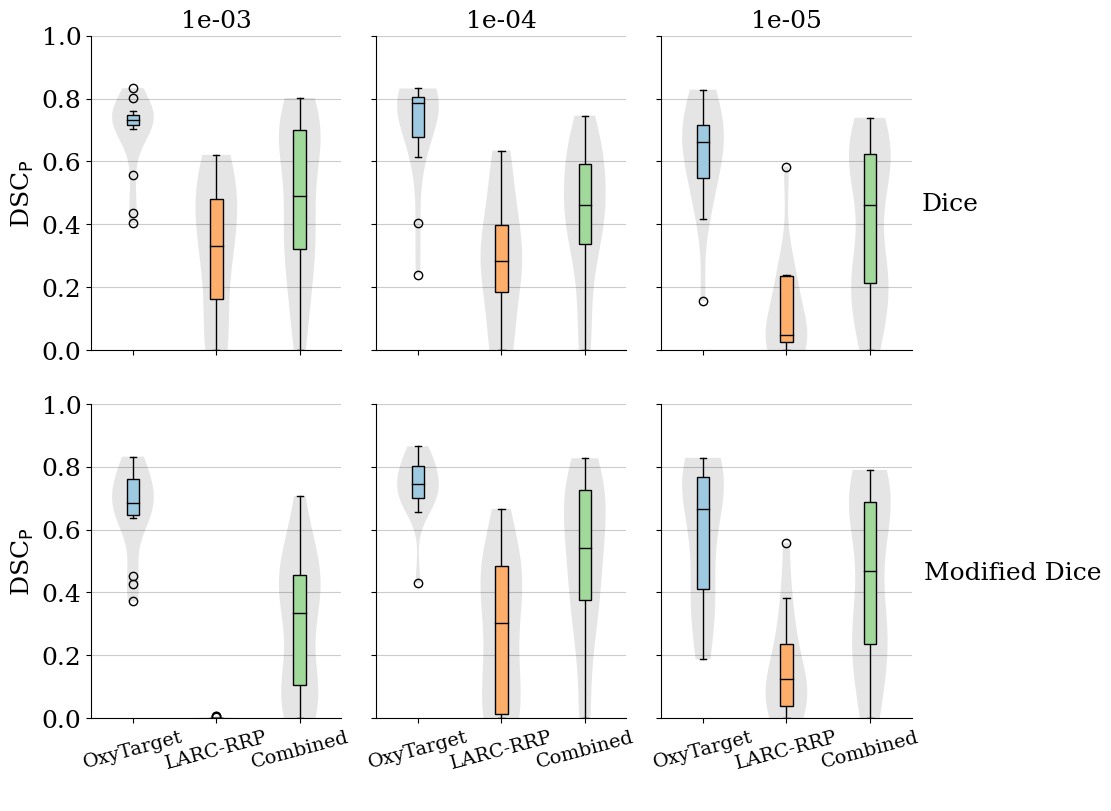

In [974]:
main_2()

## Scatter plots

In [103]:
def scatterplot(dataframe, x_value, y_value, filename, hue=None, save=False):
    fig = plt.figure(figsize=(11,8))
    sns.scatterplot(data=dataframe, x=x_value, y=y_value, hue=hue, palette='deep')
    plt.ylabel(r'DSC$_{\mathrm{P}}$')
    plt.xlabel('Patient IDs')
    #plt.title('Dataset: Combined, Learning rate: 0.00001')
    plt.ylim(-0.05,1.05)
    plt.show()
    
    if save:
        fig.savefig(filename)

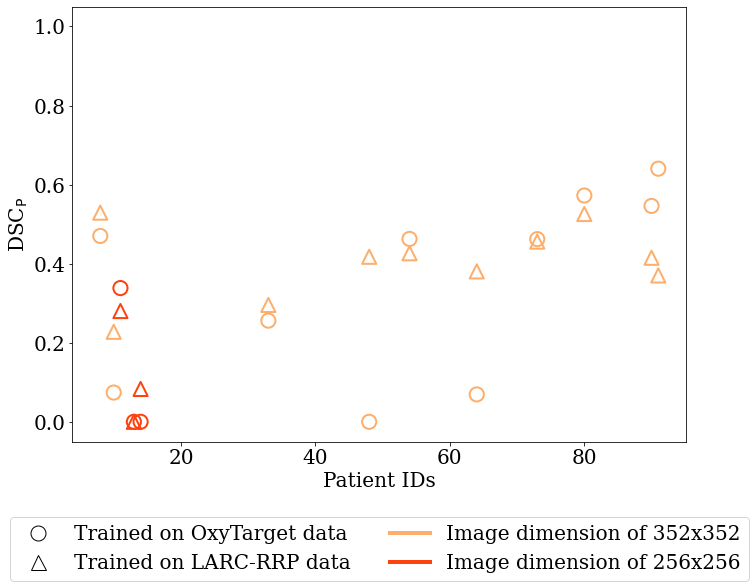

In [145]:
Oxy_ID_27_352 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/Oxy_new/Oxy_ID_27_new/patient_352.csv')
Oxy_ID_27_256 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/Oxy_new/Oxy_ID_27_new/patient_256.csv')

LARC_ID_35_352 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_35/patient_352.csv')
LARC_ID_35_256 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_35/patient_256.csv')

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Trained on OxyTarget data',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], marker='^', color='k', label='Trained on LARC-RRP data',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], color='#fdae6b', label='Image dimension of 352x352', lw=4),
                    Line2D([0], [0], color='#fe420f', label='Image dimension of 256x256', lw=4),]

fig = plt.figure(figsize=(11,8))
plt.scatter(Oxy_ID_27_352['patient_ids'], Oxy_ID_27_352['f1_score'], marker='o', color='#fdae6b', facecolors='none',s=200, linewidths=2)
plt.scatter(Oxy_ID_27_256['patient_ids'], Oxy_ID_27_256['f1_score'], marker='o', color='#fe420f', facecolors='none',s=200, linewidths=2)
plt.scatter(LARC_ID_35_352['patient_ids'], LARC_ID_35_352['f1_score'], marker='^', color='#fdae6b', facecolors='none',s=200, linewidths=2)
plt.scatter(LARC_ID_35_256['patient_ids'], LARC_ID_35_256['f1_score'], marker='^', color='#fe420f', facecolors='none',s=200, linewidths=2)
plt.ylabel(r'DSC$_{\mathrm{P}}$')
plt.xlabel('Patient IDs')
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.ylim(-0.05,1.05)
plt.show()

#fig.savefig('LARC_valPatients_trainedDiff_v2.pdf')


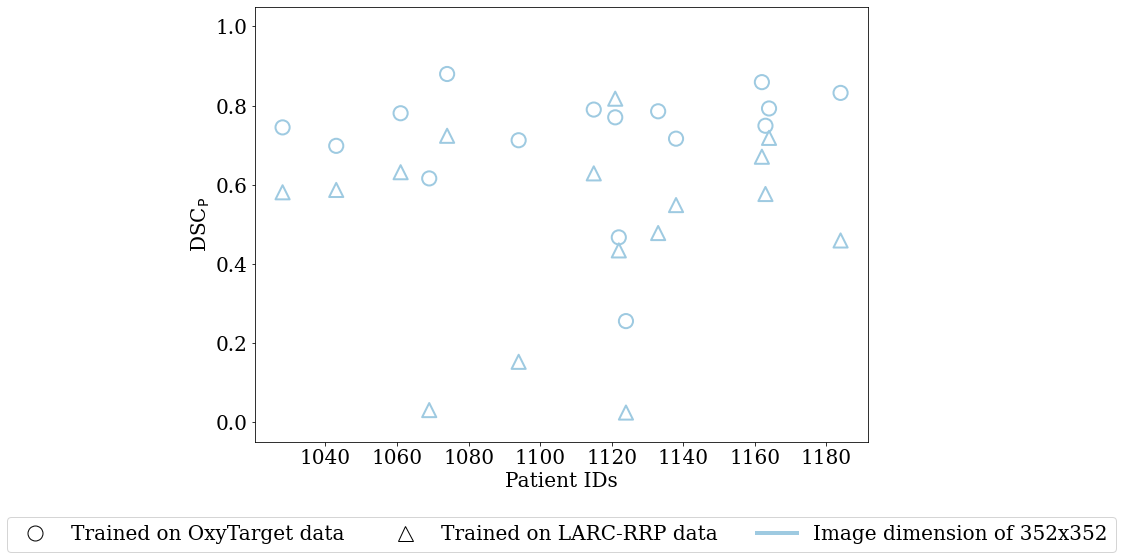

In [152]:
Oxy_ID_24 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/Oxy_new/Oxy_ID_24_new/patient.csv')
LARC_ID_38 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_38/patient.csv')

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Trained on OxyTarget data',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], marker='^', color='k', label='Trained on LARC-RRP data',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], color='#9ecae1', label='Image dimension of 352x352', lw=4),
                    ]

fig = plt.figure(figsize=(11,8))
plt.scatter(Oxy_ID_24['patient_ids'], Oxy_ID_24['f1_score'], marker='o', color='#9ecae1', facecolors='none',s=200, linewidths=2)
plt.scatter(LARC_ID_38['patient_ids'], LARC_ID_38['f1_score'], marker='^', color='#9ecae1', facecolors='none',s=200, linewidths=2)
plt.ylabel(r'DSC$_{\mathrm{P}}$')
plt.xlabel('Patient IDs')
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.ylim(-0.05,1.05)
plt.show()

fig.savefig('Oxy_valPatients_trainedDiff_v3.pdf')

In [119]:
excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
Combined = dataframe_of_f1scores(excel_path, 'Combined',['patient_352.csv','patient_256.csv'], [0,1,2,3,4,5], patient_ids=True)
Combined['Dimension'] = 352
Combined['Dimension'][26:] = 256
print(Combined)
scatterplot(Combined, 'patient_ids', '1e-05+modified dice', hue='Dimension',save=True)

    patient_ids    1e-04+Dice    1e-03+Dice    1e-05+Dice  \
0           8.0  3.742796e-01  4.586493e-01  3.168455e-01   
1          10.0  3.824719e-01  3.162307e-01  4.575202e-01   
2          33.0  1.482200e-01  1.273156e-01  7.769662e-02   
3          48.0  3.509996e-01  4.041166e-01  4.164535e-01   
4          54.0  4.541155e-01  4.588831e-01  3.141851e-01   
5          64.0  1.849959e-01  3.257951e-01  7.187295e-02   
6          73.0  3.571896e-01  4.558449e-01  1.755793e-01   
7          80.0  6.356998e-01  6.698123e-01  5.278915e-01   
8          90.0  3.550093e-01  4.452312e-01  2.035720e-01   
9          91.0  7.182102e-14  6.426570e-14  6.940974e-14   
10       1115.0  6.850677e-01  7.025625e-01  7.101163e-01   
11       1121.0  7.360561e-01  6.678380e-01  6.321875e-01   
12       1122.0  5.763660e-01  4.380303e-01  4.175091e-01   
13       1124.0  6.723814e-02  1.161710e-01  1.917404e-01   
14       1133.0  6.986026e-01  6.368142e-01  6.447318e-01   
15       1138.0  6.00843

<ipython-input-119-35e250425d50>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Combined['Dimension'][26:] = 256
/Users/ingvildaskimadde/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


TypeError: scatterplot() missing 1 required positional argument: 'filename'

## Boxplot augmentation

In [132]:
def boxplot_aug(dataframe, fontsize, labelsize, title, colors, filename, save=False):
    
    fig = plt.figure(figsize=(11,8))
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    sns.violinplot(x=dataframe['Parameters'], y=dataframe['value'], scale='width', cut=0, palette=colors)
    #sns.boxplot(x=dataframe['Parameters'], y=dataframe['value'], palette=colors)
    plt.xlabel(None)
    plt.ylabel(r'DSC$_{\mathrm{P}}$')
    plt.title(title)
    #plt.xticks(rotation=30)
    plt.ylim(-0.05,1.05)
    #plt.ylim(-0.35,1.15)
    plt.show()
    
    if save:
        fig.savefig(filename)
    

In [133]:
def catplot_aug(dataframe, fontsize, labelsize, order, filename, save=False, title=None, colors=None):
    
    fig = plt.figure()
    #sns.set_palette(sns.color_palette(colors))
    #p = {'No': sns.color_palette(colors, 1), 'Default': sns.color_palette(colors, 1), 'Best Combination': sns.color_palette(colors, 1)}
    g = sns.catplot(x='Data', y='value', col='Parameters', hue='Parameters', data=dataframe, kind='violin')#, palette=p, margin_titles=True)
    #g.map(sns.violinplot,'Data', 'value', order=order, palette=['#9ecae1','#fdae6b','#a1d99b']) #['#3182bd','#e6550d','#31a354']) ['skyblue','orange','mediumseagreen'])
    g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
   
    
    #ylabels = ['DSC', 'Modified DSC']
    row = 0
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='x-large')
        
        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    #'',
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
        row += 1
    
    g.set_xticklabels(rotation=30)
    g.set_axis_labels('', 'DSC')
    #g.axes.flat[3].set_ylabel('Modified DSC', fontsize='x-large')
    #g.axes.flat[3].set_text('', fontsize='x-large')
    g.set(ylim=(-0.35,1.1))
    #g.set(ylim=(-0.05,1.05))
    plt.show()
    
    if save:
        g.savefig(filename)
    
    

In [56]:
def new_boxplot(dataframe, fontsize, labelsize, title, colnames, colors, filename, save=False):
    
    fig, ax = plt.subplots(figsize=(11,8))

    # draw solid white grid lines
    plt.grid(color='k', alpha=0.2, fillstyle='left', axis='y', linestyle='solid')
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    
    for i in range(len(colnames)):
        filtered_data = dataframe[colnames[i]][~np.isnan(dataframe[colnames[i]])]
        parts = ax.violinplot(filtered_data, positions=[i], showmeans=False, showmedians=False,showextrema=False)
        for pc in parts['bodies']:
                pc.set_facecolor(colors[0])
                pc.set_alpha(0.4)

        ax.boxplot(filtered_data, positions=[i], showmeans=False, meanline=False, 
                    patch_artist=True, boxprops=dict(facecolor=colors[0], color='k'), 
                    medianprops=dict(color='k'),meanprops=dict(color='k'))
        
    ax.set_xticklabels(colnames)
    
    plt.xlabel(None)
    plt.ylabel(r'DSC$_{\mathrm{P}}$')
    #plt.ylabel(r'Mean DSC$_{\mathrm{S}}$')
    plt.title(title)
    plt.ylim(-0.0,1.0)
    plt.show()

    if save:
        fig.savefig(filename)


In [57]:
def main_aug():
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'

    #Define correct experiments (IDs)
    ids_LARC = [61, 60]
    ids_Oxy = [38, 40]
    ids_Comb = [28, 27]
    
    #Creating dataframes of det f1 scores of the validation patients
    Oxy = dataframe_of_f1scores(excel_path, 'Oxy_new', ['patient.csv'], ids_Oxy)
    LARC = dataframe_of_f1scores(excel_path, 'LARC', ['patient_352.csv', 'patient_256.csv'], ids_LARC)
    Combined = dataframe_of_f1scores(excel_path, 'Combined_new',['patient_352.csv','patient_256.csv'], ids_Comb)
    
    
    #Creating dictionary of dataframes
    dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}

    col_names_aug = ['No', 'Default', 'BC']
    col_names_norm = ['No', 'Z-Score', 'MH', 'MH + Z-Score']
    col_names_ts = ['All Slices', 'Tumor Slices']
    col_names_dwi = ['T2w', 'T2w + DWI']
    
    
    for key in dictionary:
        print(key)
        for i in range(len(dictionary[key].columns)):
            dictionary[key].columns.values[i] = col_names_dwi[i]
            print(dictionary[key].median())
        dictionary[key]['Data'] = key
   #     #dictionary[key] = pd.melt(dictionary[key], id_vars=['Data'], var_name=['Parameters'])
    
    
    """
    ############## TEST DATAFRAME #############################
    col_names_test = ['OxyTarget', 'LARC-RRP', 'Combined']
    
    Oxy = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/Oxy_new/Oxy_ID_38_new/patient_test.csv')
    Oxy = Oxy.drop('patient_ids', axis=1)
    #print(Oxy)
    
    LARC_352 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_62/patient_352_test.csv')
    LARC_256 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_62/patient_256_test.csv')
    LARC = LARC_352.append(LARC_256)
    LARC = LARC.drop('patient_ids', axis=1)
    
    Combined_352 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/Combined_new/Combined_ID_29_new/patient_352_test.csv')
    Combined_256 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/Combined_new/Combined_ID_29_new/patient_256_test.csv')
    Combined = Combined_352.append(Combined_256)
    Combined = Combined.drop('patient_ids', axis=1)
    
    #dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}
    data = [list(Oxy['f1_score']), list(LARC['f1_score']), list(Combined['f1_score'])]
    df = pd.DataFrame(data)
    df = df.rename(index={0: 'OxyTarget', 1: 'LARC-RRP', 2: 'Combined'})
    df = df.T
    
    print(np.median(list(df['OxyTarget'])))
    ############################################################
    """
    
    
    colors_Oxy = ['#9ecae1']#['#deebf7','#9ecae1','#3182bd']
    colors_LARC = ['#fdae6b'] #['#fee6ce','#fdae6b','#e6550d']
    colors_Comb = ['#a1d99b']#['#e5f5e0','#a1d99b','#31a354']
    colors = ['#9ecae1', '#fdae6b', '#a1d99b']
    
    #boxplot_aug(dictionary['OxyTarget'], 20, 20, '', colors_Oxy, filename='Oxy_TS_DWI_violin.pdf', save=False)
    new_boxplot(dictionary['OxyTarget'], 20, 20, '', col_names_dwi, colors_Oxy, filename='dwi_violin_corrected.pdf', save=True)
    

OxyTarget
T2w                    0.822182
1e-04+Modified Dice    0.831332
dtype: float64
T2w          0.822182
T2w + DWI    0.831332
dtype: float64
LARC-RRP
T2w                    0.553241
1e-04+Modified Dice    0.556068
dtype: float64
T2w          0.553241
T2w + DWI    0.556068
dtype: float64
Combined
T2w                    0.733144
1e-04+Modified Dice    0.738716
dtype: float64
T2w          0.733144
T2w + DWI    0.738716
dtype: float64


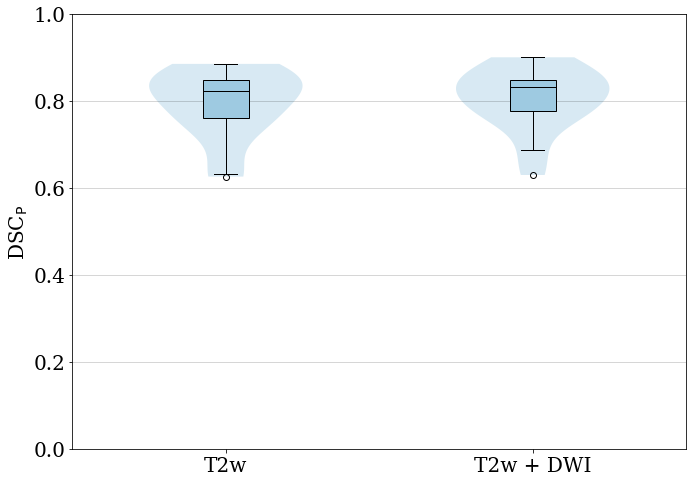

In [58]:
main_aug()

In [1009]:
def main_dimensions(dataframe, id1, id2):
    
    #path_1_dim = list(dataframe['Result path'])[id1] + '/patient.csv'
    path_1_dim_352 = list(dataframe['Result path'])[id1] + '/patient_352.csv'
    path_1_dim_256 = list(dataframe['Result path'])[id1] + '/patient_256.csv'
    path_2_dim_352 = list(dataframe['Result path'])[id2] + '/patient_352.csv'
    path_2_dim_256 = list(dataframe['Result path'])[id2] + '/patient_256.csv' #Get a list of folderpaths were the results are saved
    
    #df1 = pd.read_csv(path_1_dim)
    df1_352 = pd.read_csv(path_1_dim_352)
    df1_256 = pd.read_csv(path_1_dim_256)
    df1 = df1_352.append(df1_256, ignore_index=True)
    #df1 = df1.rename(columns={'f1_score':'One dimension \n (352x352)'})
    df1 = df1.rename(columns={'f1_score':'Dice'})
    
    df2_352 = pd.read_csv(path_2_dim_352)
    df2_256 = pd.read_csv(path_2_dim_256)
    df = df2_352.append(df2_256, ignore_index=True)
    #df2 = df.rename(columns={'f1_score':'Two dimensions \n (352x352),(256x256)'})
    df2 = df.rename(columns={'f1_score':'Modified Dice'})
    
    df = df2.join(df1.set_index('patient_ids'), on='patient_ids') 
    df = df.drop(['patient_ids'], axis=1)
    
    df['Data'] = 'LARC-RRP'
    df = pd.melt(df, id_vars=['Data'], var_name=['Parameters'])
    colors_LARC = ['#fee6ce','#fdae6b']

    boxplot_aug(df, 20, 20, '', colors_LARC, 'test', save=False)

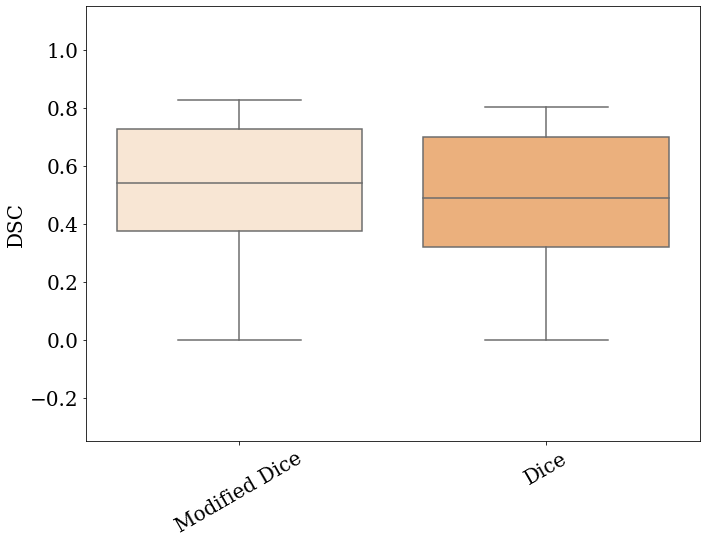

In [46]:
excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
LARC_dim = pd.read_excel(excel_path, sheet_name='Combined_new') #Create dataframe of excel sheet

main_dimensions(LARC_dim, 1,3)

## Shallow machine learning model results

In [1051]:
#text_path = '/Users/ingvild/Documents/Code/MasterThesis/Textfiles/LARC_tradSplit_patients_dict.txt'
text_path = '/Users/ingvild/Documents/Code/MasterThesis/Textfiles/LARC_Oxy_tradSplit_patients_dict.txt'
validation_patients = chdf5.read_dictionary(text_path)['val']

print(validation_patients)

{'352': [{'LARC-RRP-048', 'LARC-RRP-080', 'OxyTarget 121', 'OxyTarget 028', 'LARC-RRP-073', 'OxyTarget 069', 'OxyTarget 124', 'OxyTarget 061', 'OxyTarget 184', 'LARC-RRP-010', 'LARC-RRP-008', 'LARC-RRP-054', 'OxyTarget 122', 'LARC-RRP-090', 'LARC-RRP-033', 'OxyTarget 164', 'OxyTarget 162', 'OxyTarget 133', 'OxyTarget 138', 'OxyTarget 074', 'OxyTarget 094', 'OxyTarget 115', 'OxyTarget 043', 'OxyTarget 163', 'LARC-RRP-064', 'LARC-RRP-091'}], '256': [{'LARC-RRP-014', 'LARC-RRP-011', 'LARC-RRP-013'}]}


In [1052]:
def create_paths_from_text(patients_dict, main_folder_path, ground_truth_folder_LARC, ground_truth_folder_Oxy):
    """
    Creates paths to the machine learning results for the patients in the validation set.
    
    patients_dict: dictionary of patients in validation set
    main_folder_path: path to experiment ID from machine learning result
    returns: list of paths to machine learning results
    """
    result_paths = []
    ground_truth_paths = []
    
    for key in patients_dict:
        patient_set = patients_dict[key][0]
        
        for patient in patient_set:
            print(patient)
            if patient.startswith('Oxy'):
                patient_ID = patient.split(' ')
                if patient_ID[1].startswith('0'):
                    if patient_ID[1].endswith('0'):
                        patient_ID[1] = patient_ID[1][1] + patient_ID[1][2]
                    else:
                        patient_ID[1] = patient_ID[1].strip('0')
                patient_path = main_folder_path + '/Oxytarget_' + patient_ID[1] + '_PRE.nii'
                truth_path = ground_truth_folder_Oxy + '/Oxytarget_' + patient_ID[1] + '_PRE/Manual_an.nii'
                result_paths.append(patient_path)
                ground_truth_paths.append(truth_path)
            
            else:
                patient_path = main_folder_path + '/' + patient + '.nii'
                result_paths.append(patient_path)
                truth_path = ground_truth_folder_LARC + '/' + patient + '/1 RTSTRUCT LARC_MRS1-label.nii'
                ground_truth_paths.append(truth_path)
    
    result_paths.sort()
    ground_truth_paths.sort()
    
    return result_paths, ground_truth_paths


#experiment_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_14'
manual_folder_Oxy = '/Volumes/LaCie/MasterThesis_Ingvild/Project/Oxytarget_preprocessed'
#manual_folder_Oxy = '/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore'

#experiment_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5'
manual_folder_LARC = '/Volumes/LaCie/MasterThesis_Ingvild/Project/LARC_T2_corrected'
#manual_folder_LARC = '/Volumes/LaCie/MasterThesis_Ingvild/Data/LARC_cropped_MatchedHistZScore'

experiment_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23'

result_paths, gt_paths = create_paths_from_text(validation_patients, experiment_path, manual_folder_LARC, manual_folder_Oxy)

print(result_paths)
print(gt_paths)

LARC-RRP-048
LARC-RRP-080
OxyTarget 121
OxyTarget 028
LARC-RRP-073
OxyTarget 069
OxyTarget 124
OxyTarget 061
OxyTarget 184
LARC-RRP-010
LARC-RRP-008
LARC-RRP-054
OxyTarget 122
LARC-RRP-090
LARC-RRP-033
OxyTarget 164
OxyTarget 162
OxyTarget 133
OxyTarget 138
OxyTarget 074
OxyTarget 094
OxyTarget 115
OxyTarget 043
OxyTarget 163
LARC-RRP-064
LARC-RRP-091
LARC-RRP-014
LARC-RRP-011
LARC-RRP-013
['/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-008.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-010.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-011.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-013.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-014.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-033.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_p

In [1053]:
def calculate_dice(mask_a, mask_b):
    """
    Calculate DICE score for two binary masks (=sitk images)
    """
    npa1 = sitk.GetArrayFromImage(mask_a)
    npa2 = sitk.GetArrayFromImage(mask_b)

    dice = 2*np.count_nonzero(npa1 & npa2) / (np.count_nonzero(npa1) + np.count_nonzero(npa2))
    return dice

In [1054]:
def dsc_performance(result_paths, ground_truth_paths):
    
    dsc_scores = []
    
    for i in range(len(result_paths)):
        
        print(result_paths[i])
        predicted_mask = sitk.ReadImage(result_paths[i]) > 0
        ground_truth_mask = sitk.ReadImage(ground_truth_paths[i]) > 0
        
        dsc = calculate_dice(predicted_mask, ground_truth_mask)
        dsc_scores.append(dsc)
    
    return dsc_scores

In [1055]:
dsc_scores = dsc_performance(result_paths, gt_paths)
print(dsc_scores)

/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-008.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-010.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-011.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-013.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-014.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-033.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-048.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-054.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-064.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-073.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23/LARC-RRP-080.nii
/Volumes/LaCie/Master

## Comparing shallow machine learning and deep learning

<IPython.core.display.Javascript object>


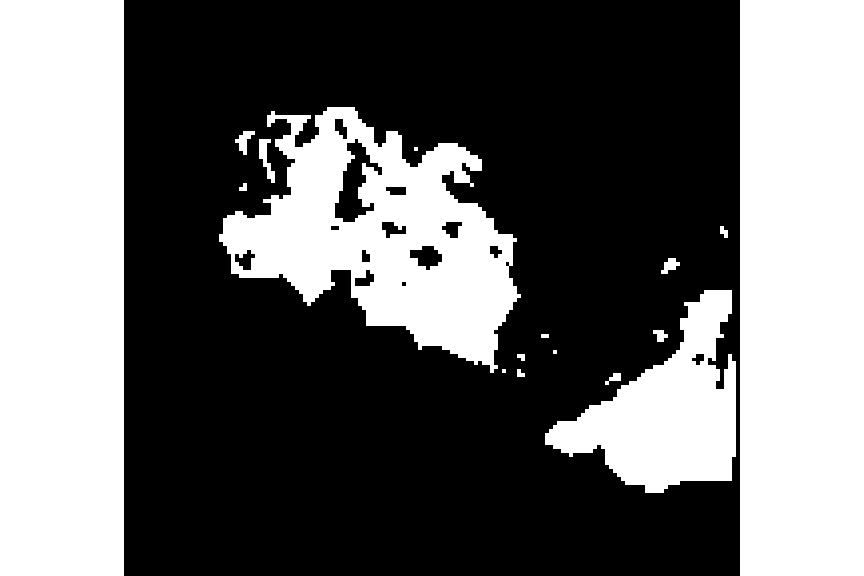

In [676]:
image_path = result_paths[1]
#mask_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/Oxytarget_preprocessed/Oxytarget_61_PRE/Manual_an.nii'
mask_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/LARC_T2_preprocessed/LARC-RRP-033/1 RTSTRUCT LARC_MRS1-label.nii'

image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(mask_path)

v = iv.Viewer(view_mode='1', mask_to_show=['a'])
v.set_image(image, label='image')
v.set_mask(mask, label='mask', color_rgb=[60, 180, 75])
v.show()

In [1059]:
def main_compare(sml_dsc):
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    
    #Define correct experiments (IDs)
    ids_LARC = [36]
    ids_Oxy = [25]
    ids_Comb = [17]
    
    #Creating dataframes of det f1 scores of the validation patients
    #Oxy = dataframe_of_f1scores(excel_path, 'Oxy_new', ['patient.csv'], ids_Oxy)
    #LARC = dataframe_of_f1scores(excel_path, 'LARC', ['patient_352.csv', 'patient_256.csv'], ids_LARC)
    #LARC = pd.read_csv('/Users/ingvild/Documents/MasterThesis/Experiments/LARC_ID_48/patient.csv')
    #LARC = LARC.drop(['patient_ids'], axis=1)
    Combined = dataframe_of_f1scores(excel_path, 'Combined_new',['patient_352.csv','patient_256.csv'], ids_Comb)
    Combined['SML'] = sml_dsc
    print(Combined)
    #Creating dictionary of dataframes
    #dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}
    dictionary = {'Combined': Combined}
    
    col_names = ['SML', 'DL']

    for key in dictionary:
        print(key)
        print(dictionary[key].columns.values[1])
        dictionary[key] = swap_columns(dictionary[key], dictionary[key].columns.values[0], dictionary[key].columns.values[1])
        for i in range(len(dictionary[key].columns)):
            dictionary[key].columns.values[i] = col_names[i]
            print(dictionary[key].median())
        dictionary[key]['Data'] = key
        #dictionary[key] = pd.melt(dictionary[key], id_vars=['Data'], var_name=['Parameters'])
    
    print(dictionary['Combined'])
        
        
    colors_Oxy = ['#3182bd','#9ecae1']#['#deebf7','#9ecae1','#3182bd']
    colors_LARC = ['#e6550d','#fdae6b'] #['#fee6ce','#fdae6b','#e6550d']
    colors_Comb = ['#31a354', '#a1d99b']#['#e5f5e0','#a1d99b','#31a354']
    
    #boxplot_aug(dictionary['LARC-RRP'], 20, 20, '', colors_LARC, filename='LARC_352_compareNew_cut0_colors_noRot_TS.pdf', save=True)
    new_boxplot(dictionary['Combined'], 20, 20, '', col_names, colors_Comb, filename='Combined_SML_DL_violin_new.pdf', save=True)
    

    1e-04+Modified Dice       SML
0              0.503802  0.388935
1              0.322519  0.456439
2              0.297452  0.554081
3              0.518211  0.545016
4              0.500058  0.433110
5              0.254180  0.374806
6              0.540900  0.681411
7              0.561797  0.502348
8              0.423900  0.296505
9              0.746964  0.260023
10             0.805910  0.513588
11             0.743734  0.478557
12             0.639753  0.603476
13             0.245394  0.408837
14             0.827067  0.538874
15             0.719763  0.482326
16             0.846028  0.494909
17             0.796550  0.618909
18             0.789021  0.595000
19             0.738979  0.763774
20             0.768097  0.594118
21             0.659059  0.703388
22             0.792782  0.807911
23             0.645090  0.346707
24             0.822628  0.454905
25             0.699668  0.753125
26             0.620587  0.659978
27             0.372947  0.759749
28            

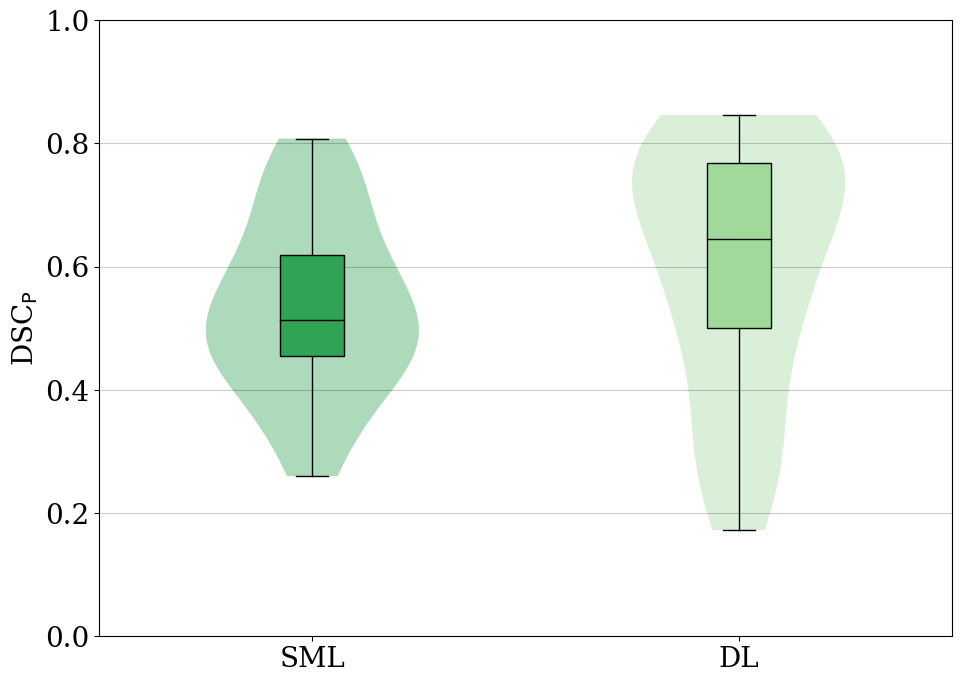

In [1060]:
main_compare(dsc_scores)

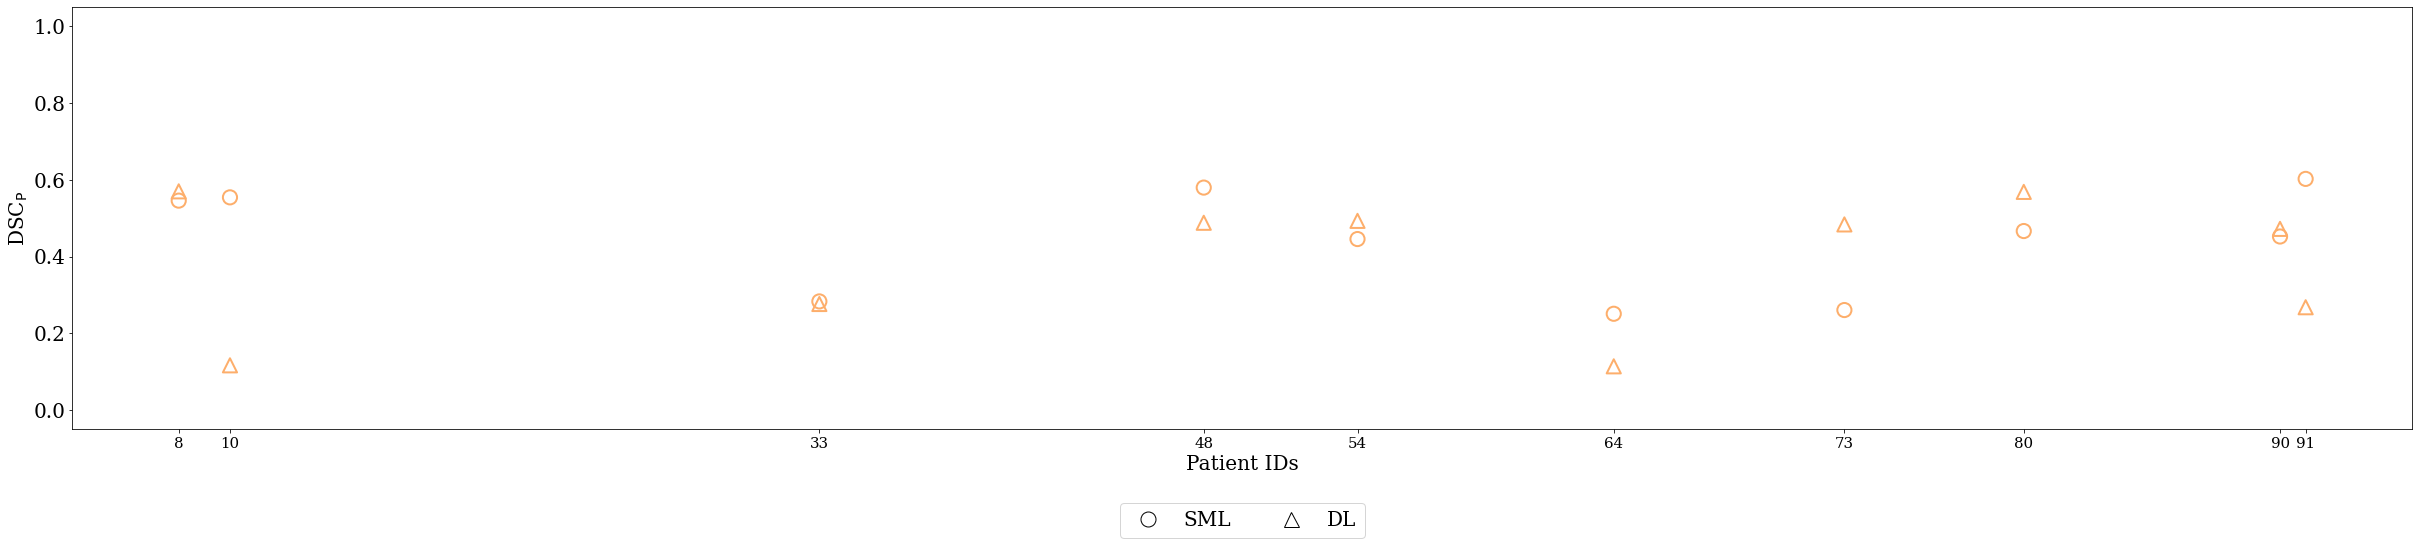

In [82]:
SML = dsc_scores
LARC_ID_43 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_43/patient.csv')

legend_elements = [Line2D([0], [0], marker='o', color='k', label='SML',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], marker='^', color='k', label='DL',
                              markerfacecolor='none', markersize=15, linestyle='none')
                    ]

fig = plt.figure(figsize=(34,8))
plt.scatter(LARC_ID_43['patient_ids'], SML, marker='o', color='#fdae6b', facecolors='none',s=200, linewidths=2)
plt.scatter(LARC_ID_43['patient_ids'], LARC_ID_43['f1_score'], marker='^', color='#fdae6b', facecolors='none',s=200, linewidths=2)
plt.ylabel(r'DSC$_{\mathrm{P}}$')
plt.xlabel('Patient IDs')
plt.xticks(LARC_ID_43['patient_ids'], size=15)
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.ylim(-0.05,1.05)
plt.tight_layout()
plt.show()

fig.savefig('LARC_352_valPatients_SML_DL.pdf')

In [173]:
def percentage_tumor_slices(gt_paths):

    tumor_slices = 0
    total_slices = 0
    tumor_voxels = 0
    total_voxels = 0

    for i in range(len(gt_paths)):
        print(gt_paths[i])
        mask = sitk.ReadImage(gt_paths[i])
        print(mask.GetSize())
        total_slices += mask.GetSize()[2]
        for j in range(mask.GetSize()[2]):
            mask_array = sitk.GetArrayFromImage(mask)
            print(mask_array.shape)
            if 1 in mask_array[j][:][:]:
                tumor_slices += 1
        tumor_voxels += np.count_nonzero(mask_array.flatten())
        total_voxels += len(mask_array.flatten())
        
    print('Number of slices with tumor:', tumor_slices)
    print('Total number of slices:', total_slices)
    print('Percentage tumor slices:', (tumor_slices/total_slices)*100)
    print('Percentage tumor voxels:', (tumor_voxels/total_voxels)*100)
    
    
percentage_tumor_slices(gt_paths)

/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_115_PRE/Manual_an.nii
(352, 352, 24)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
(24, 352, 352)
/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_121_PRE/Manual_an.nii
(352, 352, 26)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
(26, 352, 352)
/Volumes/LaCie

In [171]:
array = np.arange(1,13).reshape(2,2,3)
print(array)
print(array.shape)
print(array[0][:][:])

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
(2, 2, 3)
[[1 2 3]
 [4 5 6]]


### K-fold plots

In [36]:
def catplot_kfold(dataframe, fontsize, labelsize, order, filename, save=False, title=None, colors=None):

    fig = plt.figure()
    #sns.set_palette(sns.color_palette(colors))
    #p = {'No': sns.color_palette(colors, 1), 'Default': sns.color_palette(colors, 1), 'Best Combination': sns.color_palette(colors, 1)}
    pal1 = {'OxyTarget':'#9ecae1', 'LARC-RRP':'#fdae6b'}
    g = sns.catplot(x='Parameters', y='value', col='Data', hue='Data', data=dataframe, kind='box', palette=pal1, aspect=1.5, margin_titles=True)#, palette=p, margin_titles=True)
    #hue_order = ['OxyTarget','LARC-RRP']
    
    #g = sns.FacetGrid(dataframe, col='Data', height=5, margin_titles=True)
    #g.map(sns.boxplot, 'Parameters', 'value', order=order)#, palette=['#9ecae1', '#fdae6b','#a1d99b']) #['#3182bd','#e6550d','#31a354']) ['skyblue','orange','mediumseagreen'])
    #g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    matplotlib.rcParams["figure.figsize"] = (11, 8)
    #matplotlib.rcParams['text.usetex'] = True
   
    
    #ylabels = ['DSC', 'Modified DSC']
    #row = 0
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            #ax.set_title(ax.get_title().split('=')[1],
            #             fontsize='x-large')
            ax.set_title(' ',
                         fontsize='x-large')
        
        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    #'',
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
        #row += 1
    
    g.set(xticks=[-0.5,1,2,3,4])
    g.set_xticklabels(rotation=30, horizontalalignment='left')
    g.set_axis_labels('', r"DSC$_{\mathrm{S}}$")
    g.add_legend()
    #g.axes.flat[3].set_ylabel('Modified DSC', fontsize='x-large')
    #g.axes.flat[3].set_text('', fontsize='x-large')
    #g.set(ylim=(-0.35,1.1))
    g.set(ylim=(-0.05,1.05))
    #plt.tight_layout()
    plt.show()
    
    if save:
        g.savefig(filename)

In [1123]:
def boxplot(df1, df2, fontsize, labelsize, title, colnames, colors, filename, save=False):
    
    fig, axes = plt.subplots(figsize=(11,8), nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True)
    
    # draw solid white grid lines
    plt.grid(color='k', alpha=0.2, fillstyle='left', axis='y', linestyle='solid')
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    
    for i in range(len(colnames)):
        
        filtered_data_1 = df1[colnames[i]][~np.isnan(df1[colnames[i]])]
        axes[0].boxplot(filtered_data_1, positions=[i], showmeans=False, meanline=False, 
                    patch_artist=True, boxprops=dict(facecolor=colors[0], color='k'), 
                    medianprops=dict(color='k'),meanprops=dict(color='k'))
        
        axes[0].set(ylim=(-0.0,1.0))
        axes[0].grid(color='k', alpha=0.2, axis='y', linestyle='solid')
        axes[0].spines['right'].set_visible(False)
        axes[0].spines['top'].set_visible(False)
        
        for tick in axes[0].get_xticklabels():
                    tick.set_rotation(15)
        
    for j in range(len(colnames)):   
        
        filtered_data_2 = df2[colnames[j]][~np.isnan(df2[colnames[j]])]
        axes[1].boxplot(filtered_data_2, positions=[j], showmeans=False, meanline=False, 
                    patch_artist=True, boxprops=dict(facecolor=colors[1], color='k'), 
                    medianprops=dict(color='k'),meanprops=dict(color='k'))
        
        axes[1].set(ylim=(-0.0,1.0))
        axes[1].grid(color='k', alpha=0.2, axis='y', linestyle='solid')
        axes[1].spines['right'].set_visible(False)
        axes[1].spines['top'].set_visible(False)
        
    
        for tick in axes[1].get_xticklabels():
                    tick.set_rotation(15)
             
    axes[0].set(xlabel=' ', ylabel=r'Mean DSC$_{\mathrm{S}}$')
    
    #plt.xticks(rotation=30)
    plt.ylim(-0.0,1.0)
    plt.xticks([0, 1, 2, 3, 4], colnames)
    plt.show()
    
    if save:
        fig.savefig(filename)

In [1126]:
def main_kfold_grid():

    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    df_LARC = pd.read_excel(excel_path, sheet_name='LARC')
    df_Oxy = pd.read_excel(excel_path, sheet_name='Oxy')
    paths_LARC = list(df_LARC['Result path'])
    paths_Oxy = list(df_Oxy['Result path'])
    
    # Define correct experiments (IDs)
    ids_LARC = [2, 1, 0, 3, 4]
    column_names_LARC = ['Fold 3', 'Fold 2', 'Fold 1', 'Fold 4', 'Fold 5']
    
    df_LARC_folds = pd.DataFrame()
    for i in range(len(column_names_LARC)):
        df_temp = pd.read_csv(paths_LARC[ids_LARC[i]] + '/logs.csv')
        df_LARC_folds[column_names_LARC[i]] = df_temp['val_dice']

    df_LARC_folds = swap_columns(df_LARC_folds, 'Fold 3', 'Fold 1')
    df_LARC_folds['Data'] = 'LARC-RRP'
    
    
    ids_Oxy = [4, 1, 2, 3, 0]
    column_names_Oxy = ['Fold 5', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 1']
    
    df_Oxy_folds = pd.DataFrame()
    for i in range(len(column_names_Oxy)):
        df_temp = pd.read_csv(paths_Oxy[ids_Oxy[i]] + '/logs.csv')
        df_Oxy_folds[column_names_Oxy[i]] = df_temp['val_dice']
    
    df_Oxy_folds = swap_columns(df_Oxy_folds, 'Fold 5', 'Fold 1')
    df_Oxy_folds['Data'] = 'OxyTarget'

    #df = pd.concat([df_Oxy_folds, df_LARC_folds])
    #df = pd.melt(df, id_vars=['Data'], var_name=['Parameters'])
    print(df_Oxy_folds)
    #Plot as boxplots
    order = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
    colors = ['#9ecae1', '#fdae6b']
    #catplot_kfold(df, 12, 12, order, filename='test', save=False)
    boxplot(df_Oxy_folds, df_LARC_folds, 20, 20, '', order, colors, filename='kfolds_new.pdf', save=True)

      Fold 1    Fold 2    Fold 3    Fold 4    Fold 5       Data
0   0.102091  0.031457  0.080721  0.147441  0.045214  OxyTarget
1   0.122695  0.085598  0.082588  0.089271  0.051558  OxyTarget
2   0.389209  0.223316  0.197102  0.230705  0.181978  OxyTarget
3   0.308327  0.375146  0.386740  0.343836  0.093923  OxyTarget
4   0.390153  0.450740  0.487637  0.293436  0.421846  OxyTarget
..       ...       ...       ...       ...       ...        ...
69       NaN       NaN       NaN       NaN  0.562487  OxyTarget
70       NaN       NaN       NaN       NaN  0.546930  OxyTarget
71       NaN       NaN       NaN       NaN  0.527702  OxyTarget
72       NaN       NaN       NaN       NaN  0.567883  OxyTarget
73       NaN       NaN       NaN       NaN  0.559697  OxyTarget

[74 rows x 6 columns]


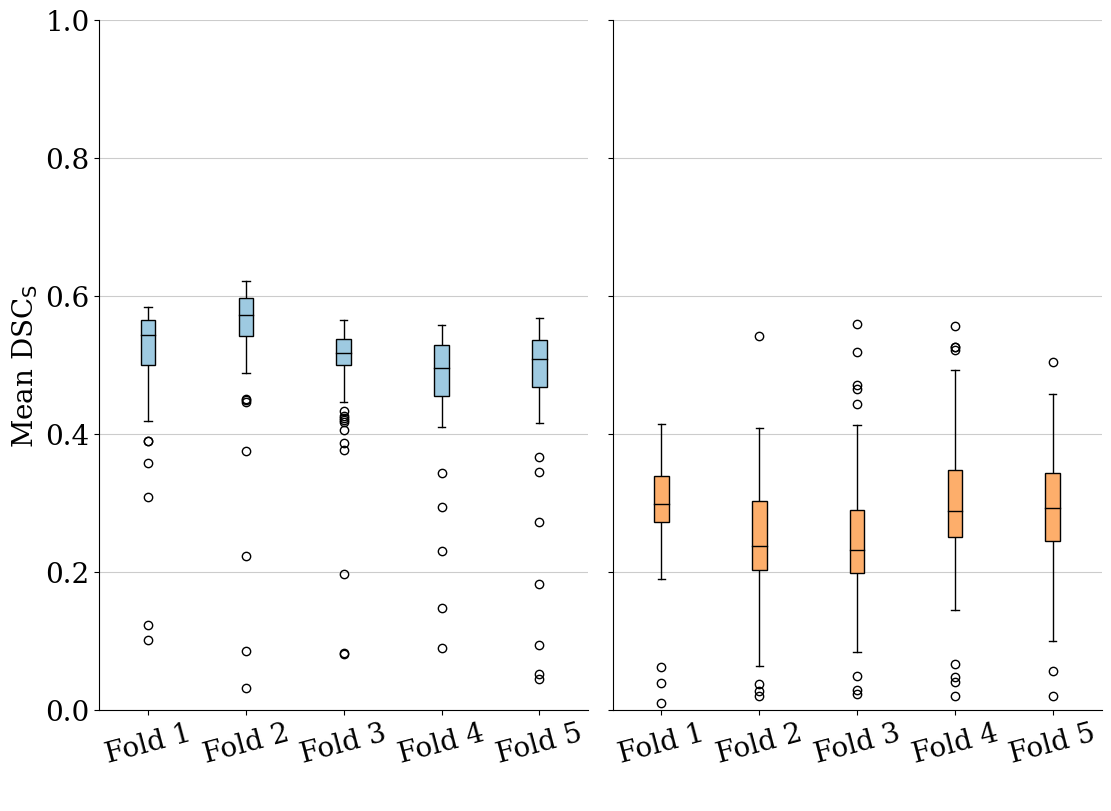

In [1127]:
main_kfold_grid()

In [50]:
def main_kfold_new():
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    df_LARC = pd.read_excel(excel_path, sheet_name='LARC')
    df_Oxy = pd.read_excel(excel_path, sheet_name='Oxy')
    paths_LARC = list(df_LARC['Result path'])
    paths_Oxy = list(df_Oxy['Result path'])
    
    
    ids_Oxy = [0, 1, 2, 3, 4]
    ids_LARC = [0, 1, 2, 3, 4]
    column_names = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
    
    df_Oxy_folds = pd.DataFrame()
    df_LARC_folds = pd.DataFrame()
    
    for i in range(len(column_names)):
        
        df_temp_Oxy = pd.read_csv(paths_Oxy[ids_Oxy[i]] + '/logs.csv')
        df_Oxy_folds[column_names[i]] = df_temp_Oxy['val_dice']
        
        df_temp_LARC = pd.read_csv(paths_LARC[ids_LARC[i]] + '/new_run/logs.csv')
        df_LARC_folds[column_names[i]] = df_temp_LARC['val_dice']
        """
        file_path_256 = paths_LARC[ids_LARC[i]] + '/new_run/patient_256.csv'
        if os.path.isfile(file_path_256):
            patient_352 = pd.read_csv(paths_LARC[ids_LARC[i]] + '/new_run/patient_352.csv')
            patient_256 = pd.read_csv(paths_LARC[ids_LARC[i]] + '/new_run/patient_256.csv')
            df_temp_LARC = patient_352.append(patient_256)
            df_temp_LARC = df_temp_LARC.reset_index(drop=True)
        else:
            df_temp_LARC = pd.read_csv(paths_LARC[ids_LARC[i]] + '/new_run/patient_352.csv')
            df_temp_LARC = df_temp_LARC.reset_index(drop=False)
        
        df_LARC_folds[column_names[i]] = df_temp_LARC['f1_score']
        """
        print(df_LARC_folds[column_names[i]].max())
    
    #df_LARC_folds.loc[len(df_LARC_folds.index)] = [None, None, None, None, 0.000]
    #print(df_LARC_folds['Fold 5'].median())
        
    print(df_Oxy_folds)
    
    
    colors_Oxy = ['#9ecae1']
    colors_LARC = ['#fdae6b']
    
    new_boxplot(df_Oxy_folds, 20, 20, '', column_names, colors_Oxy, filename='Oxy_kfold_violin_new_epochs.pdf', save=True)
    

0.5254655480384827
0.5541770458221436
0.4918678402900696
0.569392204284668
0.5018594264984131
      Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
0   0.084522  0.057001  0.102065  0.063696  0.042565
1   0.125181  0.163494  0.283019  0.087192  0.063695
2   0.283360  0.111811  0.152953  0.353167  0.363138
3   0.465472  0.368400  0.384385  0.255125  0.414233
4   0.386164  0.469669  0.308648  0.377629  0.391796
..       ...       ...       ...       ...       ...
68  0.550675       NaN  0.531822       NaN       NaN
69  0.584452       NaN  0.540183       NaN       NaN
70  0.576300       NaN       NaN       NaN       NaN
71  0.578659       NaN       NaN       NaN       NaN
72  0.573268       NaN       NaN       NaN       NaN

[73 rows x 5 columns]


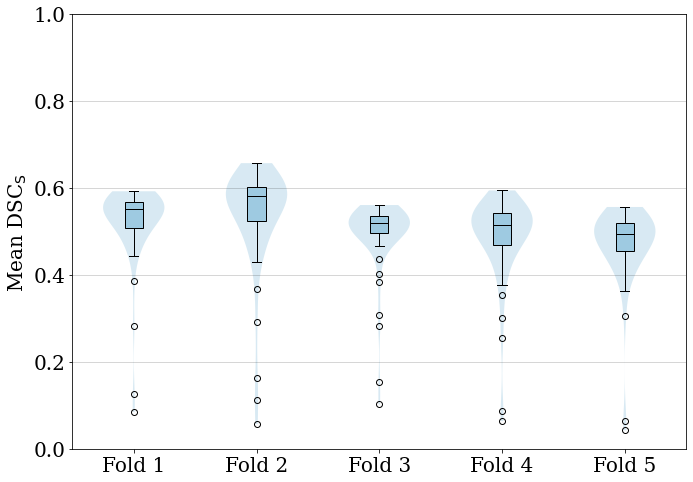

In [51]:
main_kfold_new()